In [5]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip show tensorflow
!pip install tensorflow
!pip show tensorflow
!pip install keras
!pip install seaborn
!pip install sklearn

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests,

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np # for linear algebra
import pandas as pd # data preprocessing
import tensorflow as tf # deep learning
print(tf.__version__)
from keras import layers, models # working on layers
import matplotlib.pyplot as plt # data visualization

2.17.0


In [8]:
#import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import seaborn as sns
import os
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential


In [9]:
train_data_dir = '/content/drive/MyDrive/Client_1_Project/Brain_Tumour/Brain Tumor/Training'

In [10]:
test_data_dir = '/content/drive/MyDrive/Client_1_Project/Brain_Tumour/Brain Tumor/Testing'

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE =(128,128)

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         subset = 'training',
                                                         validation_split = 0.1 ,
                                                         seed =42 )

Found 5712 files belonging to 4 classes.
Using 5141 files for training.


In [13]:
validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         subset = 'validation',
                                                         validation_split = 0.1 ,
                                                         seed =42 )

Found 5712 files belonging to 4 classes.
Using 571 files for validation.


In [14]:
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                          )

Found 1311 files belonging to 4 classes.


In [15]:
class_names = train_data.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

# Resnet50

Use the same ImageDataGenerator setup as before, with validation_split if you are using a single directory for both training and validation.

In [17]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # 20% validation split
)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [18]:
# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 1096s 7s/step - accuracy: 0.3606 - loss: 1.4395 - val_accuracy: 0.4449 - val_loss: 1.1905
Epoch 2/10
  1/160 ━━━━━━━━━━━━━━━━━━━━ 13:16 5s/step - accuracy: 0.5000 - loss: 1.1470

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5000 - loss: 1.1470 - val_accuracy: 0.4800 - val_loss: 1.2210
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1057s 7s/step - accuracy: 0.4530 - loss: 1.1345 - val_accuracy: 0.5110 - val_loss: 1.1370
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3125 - loss: 1.1749 - val_accuracy: 0.4400 - val_loss: 1.2446
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1034s 6s/step - accuracy: 0.4854 - loss: 1.0958 - val_accuracy: 0.4871 - val_loss: 1.1471
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6250 - loss: 0.9445 - val_accuracy: 0.4400 - val_loss: 1.1598
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1104s 6s/step - accuracy: 0.5003 - loss: 1.0809 - val_accuracy: 0.4835 - val_loss: 1.1331
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.6562 - loss: 0.9075 - val_accuracy: 0.4800 - val_loss: 1.4951
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1024s 6s/step - accuracy: 0.4891 - loss: 1.0765 - val_accuracy

Fine-Tuning

In [20]:
# Unfreeze some layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1192s 7s/step - accuracy: 0.3829 - loss: 4.6317 - val_accuracy: 0.4136 - val_loss: 1.2574
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - accuracy: 0.4062 - loss: 1.1712 - val_accuracy: 0.4000 - val_loss: 1.2655
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1166s 7s/step - accuracy: 0.5321 - loss: 1.0378 - val_accuracy: 0.3566 - val_loss: 1.5511
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5625 - loss: 1.0719 - val_accuracy: 0.4000 - val_loss: 1.4932
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1162s 7s/step - accuracy: 0.5510 - loss: 1.0009 - val_accuracy: 0.5331 - val_loss: 1.0438
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5625 - loss: 0.8129 - val_accuracy: 0.4800 - val_loss: 1.1407
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1152s 7s/step - accuracy: 0.5772 - loss: 0.9438 - val_accuracy: 0.5938 - val_loss: 0.9763
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6562 - loss: 0.8767 -

In [21]:
model_save_path = '/content/drive/MyDrive/Client_1_Project/Brain_Tumour/brain_tumor_resnet50_model.h5'
model.save(model_save_path)


In [22]:
# Load the model from HDF5 file
model_load_path = '/content/drive/MyDrive/Client_1_Project/Brain_Tumour/brain_tumor_resnet50_model.h5'
loaded_model = load_model(model_load_path)
print("Model loaded successfully.")
loaded_model.summary()


Model loaded successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,689,990 (98.00 MB)

 Trainable params: 6,567,940 (25.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

In [23]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 380s 9s/step - accuracy: 0.5363 - loss: 1.0954
Test Accuracy: 58.28%


In [24]:
#Generate predictions for the entire test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step


In [28]:
# Get true labels from the test generator
y_true = test_generator.classes

# Define class labels
class_labels = {0: 'Class 0', 1: 'Class 1', 2: 'Class 2', 3: 'Class 3'}
report = classification_report(y_true, y_pred_classes, target_names=list(class_labels.values()))
print(report)

              precision    recall  f1-score   support

     Class 0       0.50      0.53      0.52       300
     Class 1       0.48      0.43      0.46       306
     Class 2       0.83      0.76      0.80       405
     Class 3       0.50      0.59      0.54       300

    accuracy                           0.59      1311
   macro avg       0.58      0.58      0.58      1311
weighted avg       0.60      0.59      0.60      1311



In [29]:
# Overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 59.27%


In [30]:
# F1-Score for each class
f1_scores = f1_score(y_true, y_pred_classes, average=None)
print(f'F1 Scores: {dict(zip(class_labels.values(), f1_scores))}')

F1 Scores: {'Class 0': 0.5162337662337663, 'Class 1': 0.45783132530120485, 'Class 2': 0.7958656330749354, 'Class 3': 0.543778801843318}


In [31]:
# Tumor-wise (class-specific) accuracy
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print(f'Tumor-wise Accuracy: {dict(zip(class_labels.values(), class_wise_accuracy))}')

Tumor-wise Accuracy: {'Class 0': 0.53, 'Class 1': 0.434640522875817, 'Class 2': 0.7604938271604939, 'Class 3': 0.59}


In [33]:
# Overall precision, recall, and F1-Score (macro, micro, weighted)
from sklearn.metrics import recall_score
overall_precision = precision_score(y_true, y_pred_classes, average='macro')
overall_recall = recall_score(y_true, y_pred_classes, average='macro')
overall_f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f'Overall Precision: {overall_precision * 100:.2f}%')
print(f'Overall Recall: {overall_recall * 100:.2f}%')
print(f'Overall F1 Score: {overall_f1 * 100:.2f}%')

Overall Precision: 58.14%
Overall Recall: 57.88%
Overall F1 Score: 57.84%


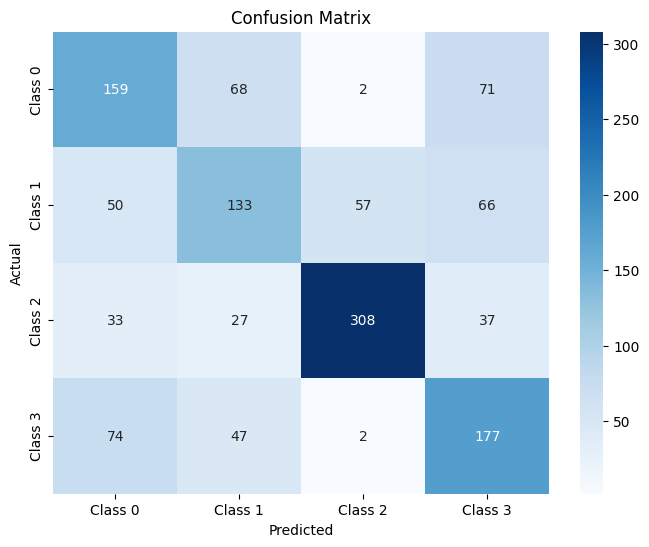

In [34]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

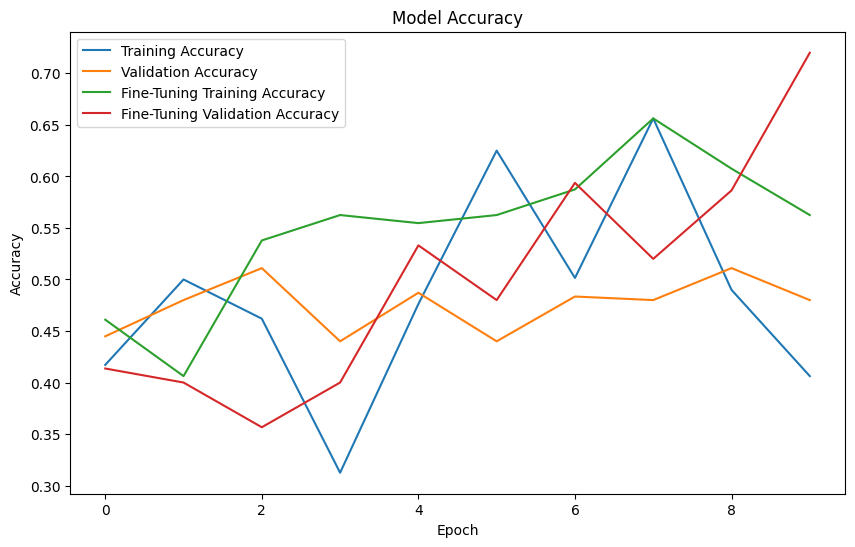

In [35]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

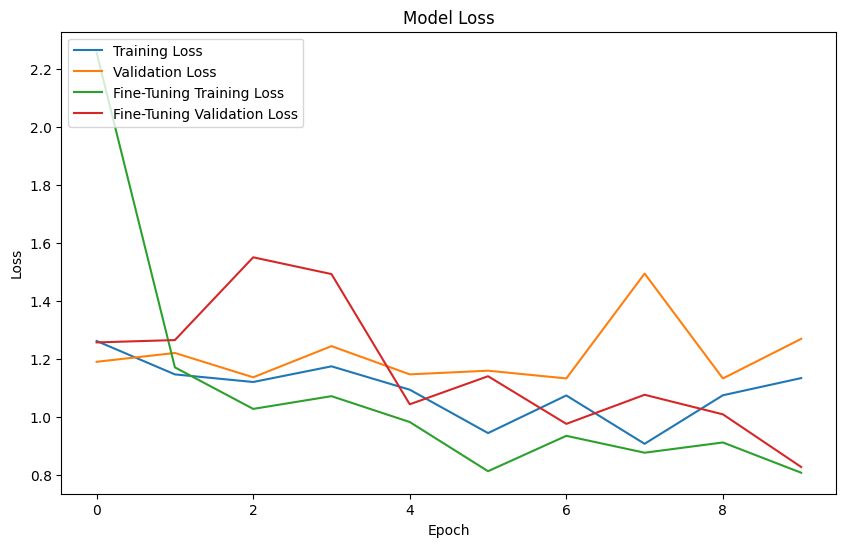

In [36]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


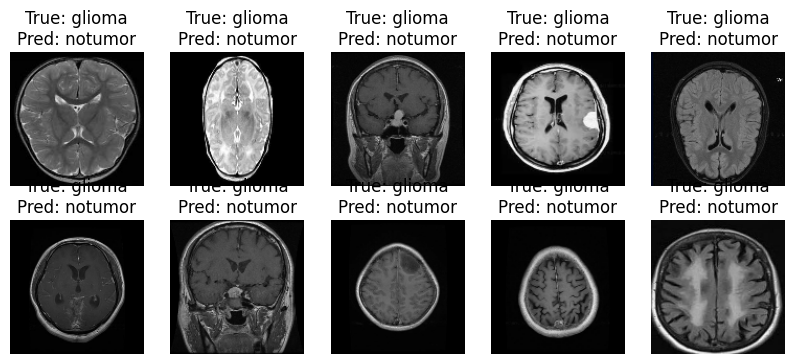

In [41]:
# Plot sample predictions True & Predict
plt.figure(figsize=(10, 4))
for image_batch, label_batch in test_data.take(1):
    # Resize images to (224, 224)
    resized_images = tf.image.resize(image_batch, [224, 224])
    # Get predictions for the batch of images
    predictions = model.predict(resized_images) # Assuming 'model' is your trained model
    predicted_class_names = [class_names[np.argmax(p)] for p in predictions] # Extract predicted class names

    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        true_label = class_names[np.argmax(label_batch[i])]
        predicted_label = predicted_class_names[i]
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
plt.show()

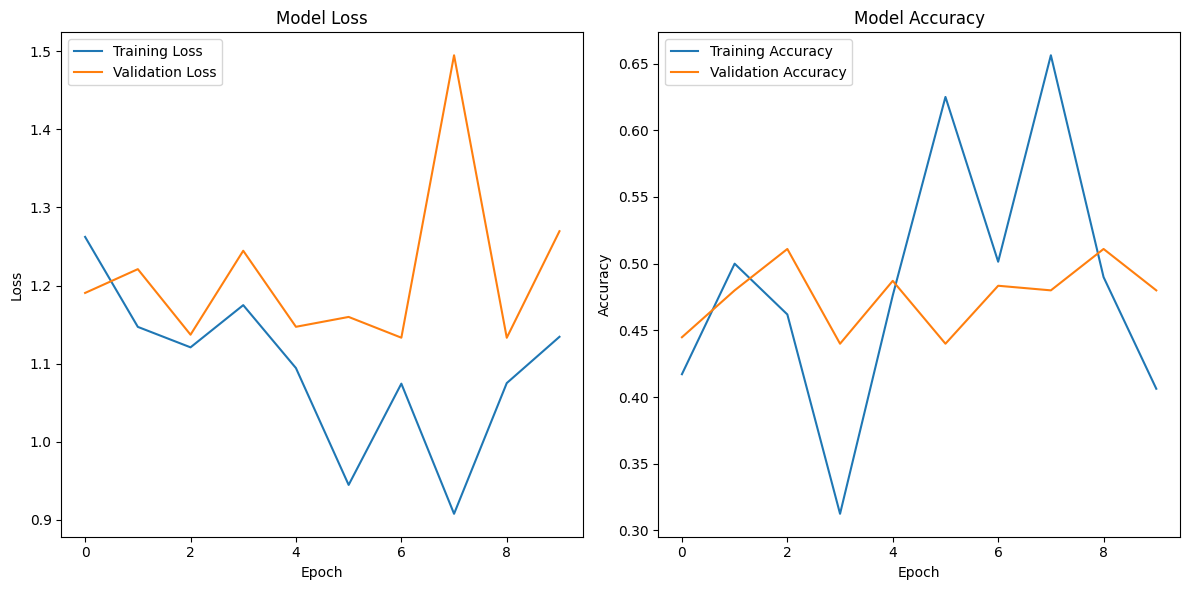

In [42]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

# Training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout()
plt.show()

In [43]:
# Get the final training accuracy
training_accuracy = history.history['accuracy'][-1] * 100

# Get the final validation accuracy
validation_accuracy = history.history['val_accuracy'][-1] * 100

print(f"Final Training Accuracy: {training_accuracy:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracy:.2f}%")


Final Training Accuracy: 40.62%
Final Validation Accuracy: 48.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


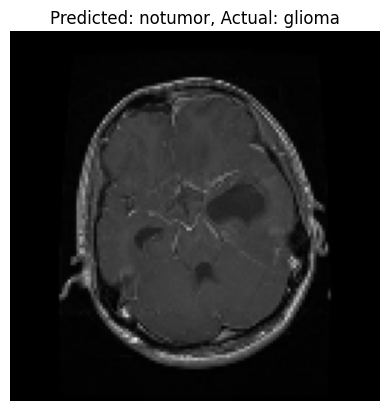

The model incorrectly identified the tumor type.


In [44]:
# Select a random batch of images and labels from the test data
for image_batch, label_batch in test_data.take(1):
    random_index = random.randint(0, len(image_batch) - 1)

    # Get the corresponding image and label
    random_image = image_batch[random_index].numpy()
    true_label = label_batch[random_index].numpy()

    random_image_expanded = np.expand_dims(random_image, axis=0)
    prediction = model.predict(random_image_expanded)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the image
    plt.imshow(random_image.astype('uint8'))
    plt.title(f"Predicted: {class_names[predicted_class]}, Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Check if the prediction is correct
    if predicted_class == true_label:
        print("The model correctly identified the tumor type.")
    else:
        print("The model incorrectly identified the tumor type.")


In [48]:
model.save('/content/drive/MyDrive/Client_1_Project/Brain_Tumour/Brain_Tumor/CNN_Model_Brain_Augest.h5')